# Tidy Data with Pandas

SyntaxError: invalid syntax (278838110.py, line 1)

In [1]:

import numpy as np #
import pandas as pd 
from dateutil.parser import parse

import requests
from bs4 import BeautifulSoup

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticks

In [10]:
raw_df = pd.read_csv("Oil spillage dataset.csv")
raw_df.head(10)

,Spill / Vessel,Location,Dates,Min Tonnes,Max Tonnes,Owner
0,2023 Princess Empress oil spill,"Philippines, Pola, Oriental Mindoro",28 February 2023,881,881,RDC Reield Marine Services
1,2022 Keystone Pipeline oil spill,"United States, Washington County, Kansas",7 December 2022,"18,516.94","18,516.94",TC Energy
2,2022 Chesire oil truck rollover,"United States, Cheshire, Connecticut",11 February 2022,62.98,62.98,Libretti and Sons Fuel
3,2022 Callao oil spill,"Ventanilla District, Callao, Peru",15 January 2022,"1,626.39","1,861.68",Repsol
4,2021 New Orleans oil spill,"United States, St. Bernard Parish, Louisiana",27 December 2021,944.11,944.11,PBF Energy
5,2021 Orange County oil spill,"United States, Orange County, California shore...",1 October 2021,424.42,424.42,Amplify Energy
6,2021 Mediterranean oil spill/Emerald,"Israel, Lebanon, Mediterranean shoreline",11 February 2021,NaN,NaN,Emerald Marine Ltd
7,Chevron Richmond Refinery,"United States, Richmond, California",9 February 2021,1.9,1.9,Chevron Corporation
8,2020 Colonial Pipeline oil spill,"United States, North Carolina, Huntersville",14 August 2020,"63,000","63,000",Colonial Pipeline
9,El Palito Refinery,"Venezuela, Golfo Triste",8 August 2020,"2,700","2,700",Petróleos de Venezuela


In [3]:
def clean_column_names(df):
    return df.rename(columns = {'Spill / Vessel':'spill', 'Dates':'date', 'Min Tonnes':'min_tonnes', 'Max Tonnes':'max_tonnes',
                               'Location':'location'})

def clean_columns(df):
    return (df.assign(spill = df.spill.str.lower().astype('str'),
                    min_tonnes = df.min_tonnes.str.replace(',','').str.replace("unknown", 'nan').astype('float').fillna(0),
                    max_tonnes = df.max_tonnes.str.replace(',','').str.replace("unknown", 'nan').astype('float').fillna(0),
                    country = df.location.str.split(",").str[0],
                    region = df.location.str.split(",").str[1]
                )
           )

def clean_date(df):
    df['date'] = df['date'].str.replace('–','-')\
                            .str.strip(' ')\
                            .str.split('-').str[0]\
                            .replace('1950\'s ', '1 January 1950')\
                            .replace('1940s ', '1 January 1940')\
                            .apply(parse)
    return df

def extract_transportation(df):
    ship_name_regex = fetch_ship_names()
    return (df.assign(transportation = np.select([df.spill.str.contains(rf'(?:{ship_name_regex})'),
              df.spill.str.contains(r'(?:truck|car)'),
              df.spill.str.contains(r'(?:train|rail)'),
              df.spill.str.contains(r'(?:line)')],
             ['ship','truck','train', 'pipeline'],
             default='platform'),
             
     )
    )

#Using the fact that ship names are italicized, I read the Wikipedia table containing the list of oil spills appending if the name is italicized
def fetch_ship_names():
    r = requests.get("https://en.wikipedia.org/wiki/List_of_oil_spills")
    soup = BeautifulSoup(r.text)
    
    ship_names = []
    for row in soup.find_all('table')[1].tbody.find_all('tr')[1:]:
        first_column = row.find_all('td')[0].find_all('i')
        if len(first_column) > 0:
            #print(fir.get_text())
            ship_names.append(first_column[0].get_text().lower())
    ship_names.extend(['grillo', 'luckenbach']) # additional ships that are not named but are ships nonetheless
    ship_name_regex = "|".join(ship_names)
    
    return ship_name_regex

In [14]:
df = (raw_df.pipe(clean_column_names).pipe(clean_columns).pipe(clean_date).pipe(extract_transportation).sort_values('date'))

df.head(10)

,spill,location,date,min_tonnes,max_tonnes,Owner,country,region,transportation
276,ss petriana,"Australia, Port Phillip, Victoria",1903-11-30,1300.0,1300.0,Asiatic Petroleum Company,Australia,Port Phillip,ship
275,thomas w. lawson,"United Kingdom, Isles of Scilly",1907-12-14,7400.0,7400.0,NaN,United Kingdom,Isles of Scilly,ship
274,lakeview gusher,"United States, Kern County, California",1910-03-14,1230000.0,1230000.0,NaN,United States,Kern County,platform
273,ss frank h. buck / ss president coolidge colli...,"United States, San Francisco Bay, California",1937-03-06,8870.0,8870.0,NaN,United States,San Francisco Bay,ship
270,"greenpoint, brooklyn","United States, Newtown Creek, Greenpoint, Broo...",1940-01-01,55200.0,97400.0,NaN,United States,Newtown Creek,platform
272,scuttled tanker el grillo,"Iceland, Seyðisfjörður",1944-02-09,0.0,0.0,NaN,Iceland,Seyðisfjörður,ship
271,seria field 14 wells,Brunei,1945-06-12,0.0,0.0,NaN,Brunei,NaN,platform
269,lincoln,"South Africa, Quoin Point near Cape Town",1946-04-09,0.0,0.0,NaN,South Africa,Quoin Point near Cape Town,ship
267,ss douglas victory,"United States, Wilmington, California",1948-03-27,0.0,0.0,NaN,United States,Wilmington,ship
268,ss river raisin,United States,1948-04-09,0.0,0.0,NaN,United States,NaN,ship


## Exploratory Data Analysis

Text(0.5, 0.98, 'Estimated Cumulative Tonnes of Oil Spills')

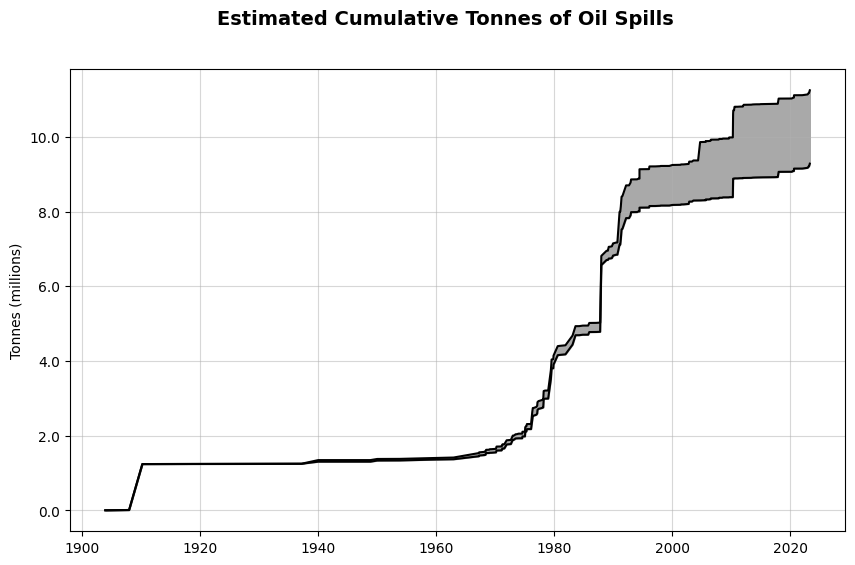

In [19]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(df['date'], df['min_tonnes'].cumsum(), color='black')
ax.plot(df['date'], df['max_tonnes'].cumsum(), color='black')
ax.fill_between(x=df['date'], y1=df['min_tonnes'].cumsum(), y2=df['max_tonnes'].cumsum(), color='darkgrey')
ax.grid('.', alpha=0.5)
ax.set_ylabel("Tonnes (millions)")
ax.get_yaxis().set_major_formatter(mticks.FuncFormatter(lambda x, p: format(x/1000000, ',')))

plt.suptitle("Estimated Cumulative Tonnes of Oil Spills", weight='bold', size=14)

In [20]:
df.transportation.value_counts()

transportation
ship        136
platform    107
pipeline     29
truck         3
train         2
Name: count, dtype: int64

Text(0.5, 0.98, 'Estimated Cumulative Tonnes of Oil Spills, by Incident Type')

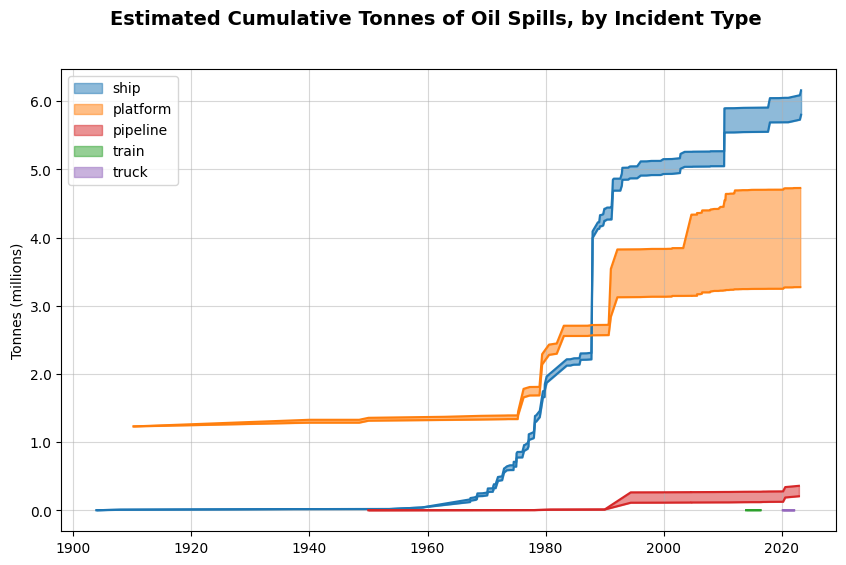

In [23]:
fig, ax = plt.subplots(figsize=(10,6))
colors = ['tab:blue', 'tab:orange', 'tab:red', 'tab:green', 'tab:purple']

for i, method in enumerate(df.transportation.unique()):
    dft = df.query("transportation == @method").sort_values('date').copy()
    
    ax.plot(dft['date'], dft['min_tonnes'].cumsum(), colors[i])
    ax.plot(dft['date'], dft['max_tonnes'].cumsum(), colors[i])
    ax.fill_between(x=dft['date'], y1=dft['min_tonnes'].cumsum(), y2=dft['max_tonnes'].cumsum(), color=colors[i], alpha=0.5, label=method)

    ax.grid('-', alpha=0.5)
ax.set_ylabel("Tonnes (millions)")
ax.get_yaxis().set_major_formatter(mticks.FuncFormatter(lambda x, p: format(x/1000000, ',')))
ax.legend()

plt.suptitle("Estimated Cumulative Tonnes of Oil Spills, by Incident Type", weight='bold', size=14)

In [29]:
#Understanding Lambda

str1 = 'GeeksforGeeks'
 
# lambda returns a function object
rev_upper = lambda string: string.upper()[::-1]
print(rev_upper(str1))

SKEEGROFSKEEG


In [30]:
#Difference between "def" and "lambda" function

def cube(y):
    return y*y*y
 
 
lambda_cube = lambda y: y*y*y
 
 
# using function defined
# using def keyword
print("Using function defined with `def` keyword, cube:", cube(5))
 
# using the lambda function
print("Using lambda function, cube:", lambda_cube(5))

Using function defined with `def` keyword, cube: 125
Using lambda function, cube: 125
